/tmp/ipykernel_32425/1368582642.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


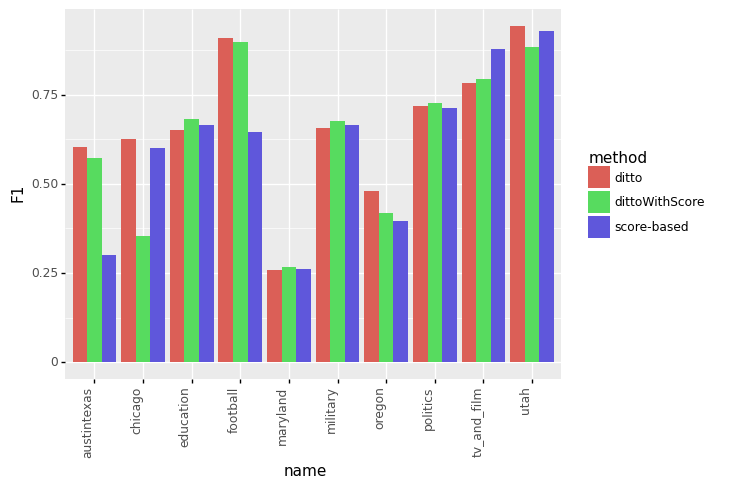

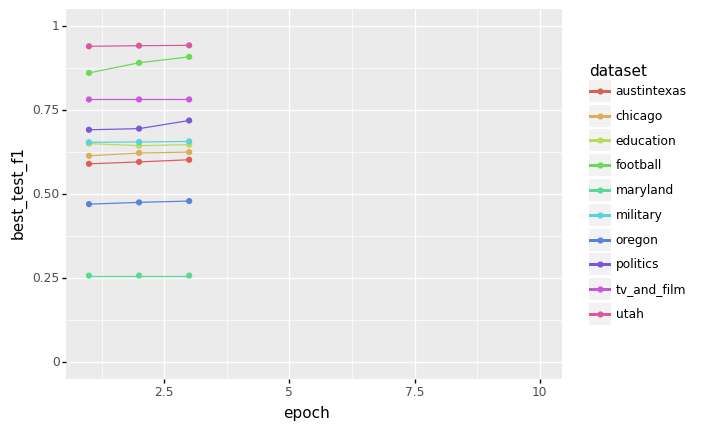

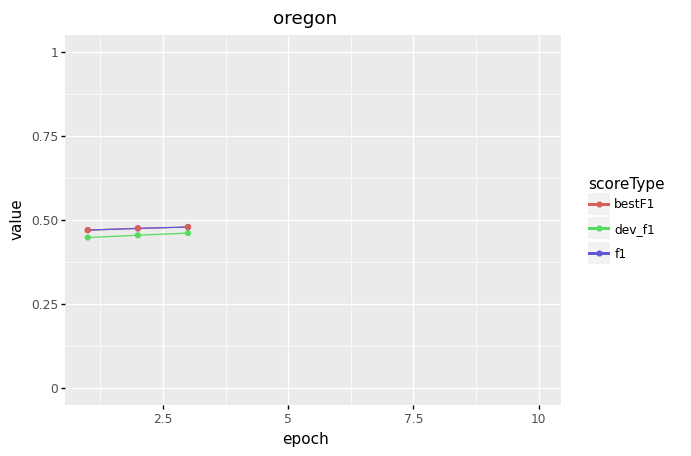

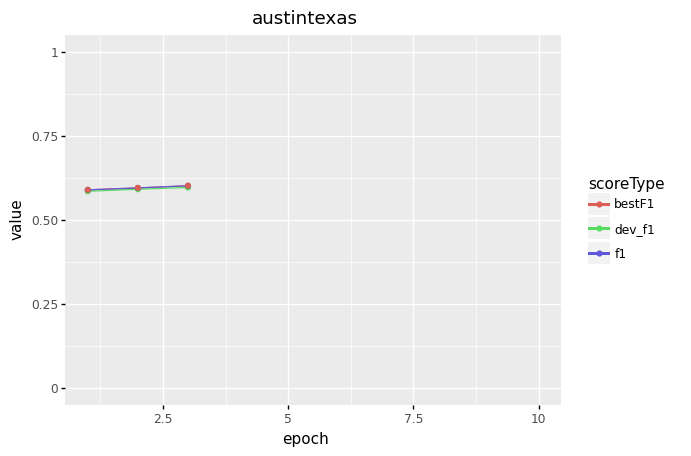

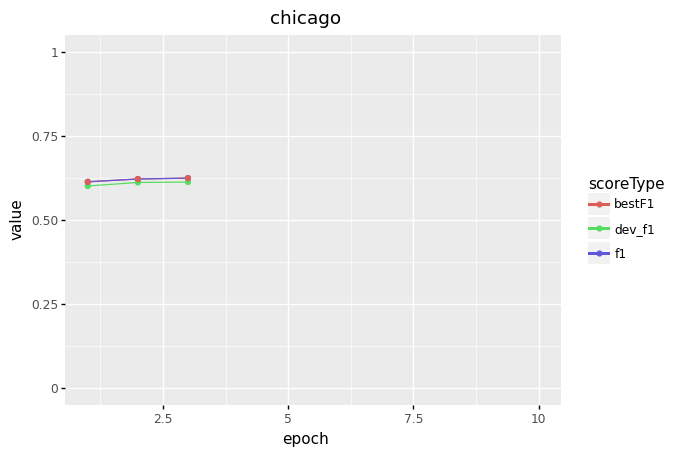

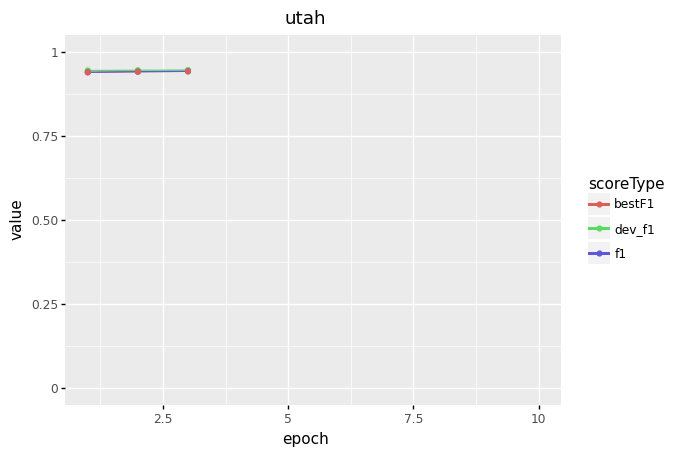

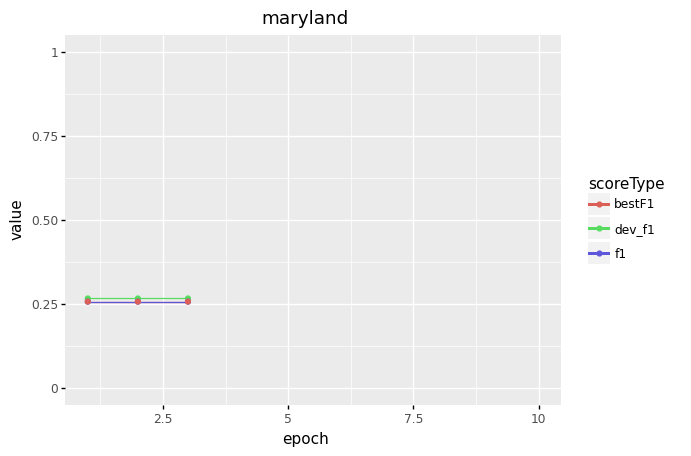

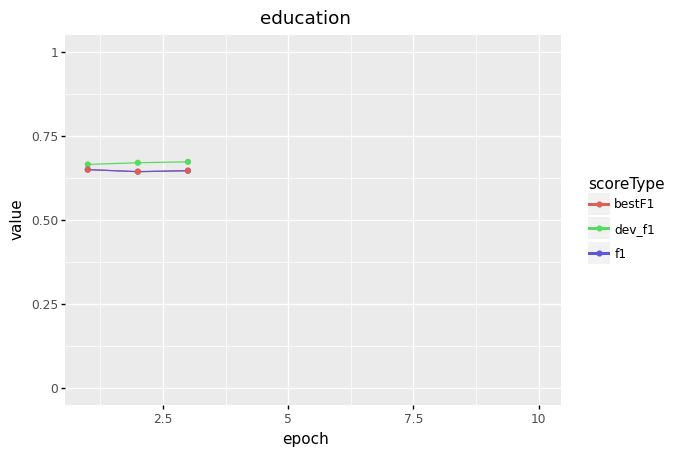

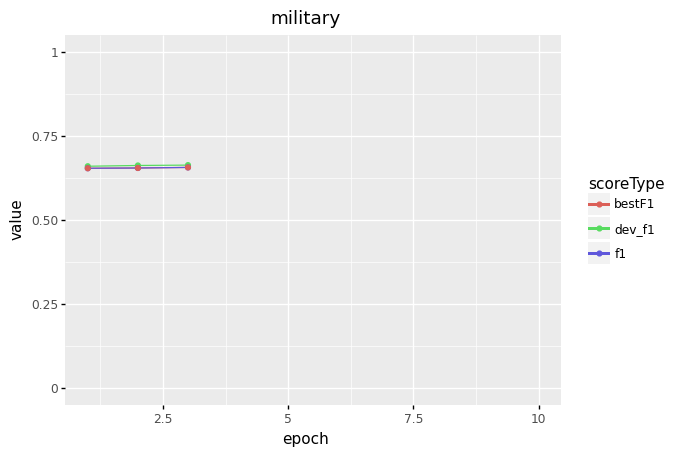

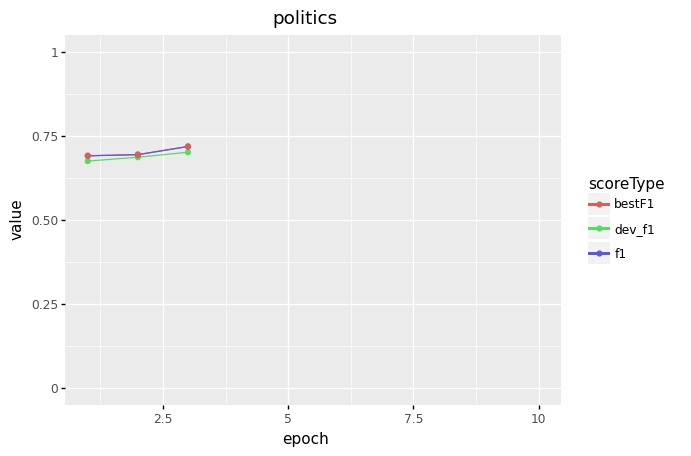

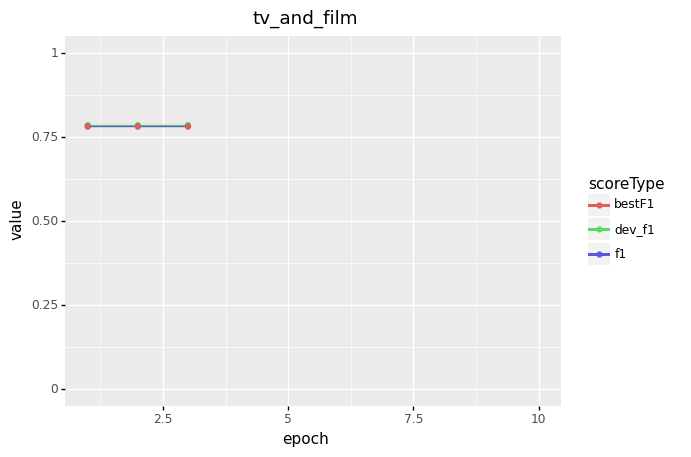

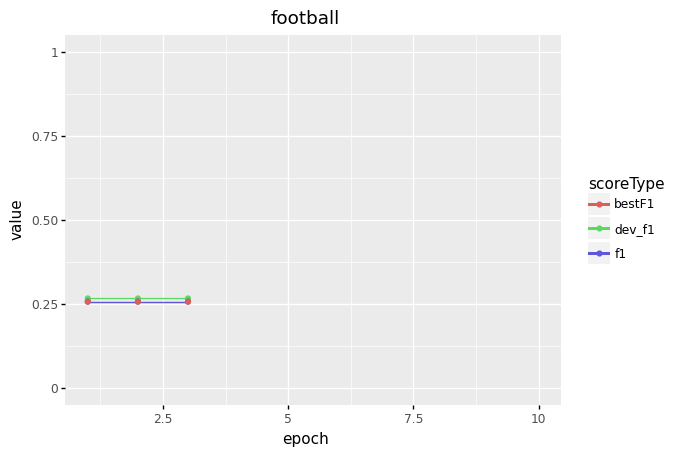

In [1]:
import pandas as pd
from plotnine import *
from plotnine.data import *
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix, precision_recall_curve
import numpy as np



def readDittoDF(path,method):
    dittoDF = pd.read_csv(path)
    dittoDF["name"]=dittoDF["dataset"]
    dittoDF["F1"]=dittoDF["best_test_f1"]
    dittoDF["method"]=method
    return dittoDF

dittoDF = readDittoDF("localData/dittoTrainProcessSocrataAndWikipedia.csv","ditto")
dittoDFWithIDANDSCore = readDittoDF("localData/dittoTrainAllWithIDAndScore.csv","dittoWithScore")

dfPivoted = pd.read_csv("localData/dittoTrainEpochsPivot.csv")
bestF1ScoreBased = pd.read_csv("localData/bestF1ScoreBased.csv")
bestF1ScoreBased["method"]="score-based"

newDFToPlot = dittoDF.append(bestF1ScoreBased).append(dittoDFWithIDANDSCore)
#print(ggplot(bestF1ScoreBased) + geom_point(aes(x='recall',y='Precision',color="name")))
plot = ggplot(newDFToPlot,aes(x = 'name',y='F1',fill='method')) + geom_col(position=position_dodge()) + theme(axis_text_x = element_text(angle=90, hjust=1))
print(plot)

plot = ggplot(dittoDF,aes(x = 'epoch',y='best_test_f1',color='dataset')) + geom_line() + geom_point()  + xlim(1, 10) + ylim(0, 1)
print(plot)

datasets = dittoDF["dataset"].unique()
for ds in datasets:
    dfFiltered = dfPivoted[dfPivoted["dataset"]==ds]
    #print(dfFiltered)
    plot = ggplot(dfFiltered,aes(x = 'epoch',y='value',color='scoreType')) + geom_line() +  geom_point() + ylim(0, 1) + xlim(1, 10) + ggtitle(ds)
    print(plot)


In [3]:
#target precision
print("TODO! - target precision")

TODO! - target precision
